ใน ep นี้เราจะเรียนรู้

# 0. Install

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Install Library ที่จำเป็น

In [36]:
## Colab
! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


เช็ค GPU

In [37]:
! nvidia-smi

Wed Dec 18 10:50:46 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   1449MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Import

Import Library ที่จะใช้ ในที่นี้คือ fastai และ fastai.text 

In [0]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.callbacks.mem import *

In [0]:
# import fastai.utils.collect_env
# fastai.utils.collect_env.show_install()

สำหรับ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) เราจะกำหนด path ที่เก็บ DataSet และ Mount Google Drive 

In [40]:
dataset = '26i-giga-fren'

## Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/drive/My Drive/datasets/')

# ## VM
# config_path = Path(os.getenv("HOME"))
# data_path_base = Path(os.getenv("HOME")'/datasets/')

data_path = data_path_base/dataset

from google.colab import drive
drive.mount(str(config_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Dataset

ในเคสนี้เราจะใช้ giga-fren คือ Giga-word corpus สำหรับแปลภาษาระหว่างภาษาฝรั่งเศส-ภาษาอังกฤษ (French-English) จากงาน WMT2010 รวบรวมโดย Chris Callison-Burch

In [41]:
data_path

PosixPath('/content/drive/My Drive/datasets/26i-giga-fren')

ดูว่ามีไฟล์อะไรบ้าง

In [42]:
path = data_path/'giga-fren'
path.ls()

[PosixPath('/content/drive/My Drive/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/content/drive/My Drive/datasets/26i-giga-fren/giga-fren/questions_easy.csv'),
 PosixPath('/content/drive/My Drive/datasets/26i-giga-fren/giga-fren/.ipynb_checkpoints'),
 PosixPath('/content/drive/My Drive/datasets/26i-giga-fren/giga-fren/databunch-small-questions.pkl'),
 PosixPath('/content/drive/My Drive/datasets/26i-giga-fren/giga-fren/models')]

# 3. Preprocess

In [0]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    samples = to_data(samples)
    max_len_x, max_len_y = max([len(s[0]) for s in samples]), max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx

    if backwards: pad_first = not pad_first
    for i, s in enumerate(samples): 
        if pad_first:
            res_x[i, -len(s[0]):], res_y[i, -len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
        else:
            res_x[i, :len(s[0]):], res_y[i, :len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
    if backwards: res_x, res_y = res_x.flip(1), res_y.flip(1)
    return res_x, res_y

In [0]:
class Seq2SeqDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', 
               bs:int=32, val_bs:int=None, pad_idx=1, dl_tfms=None, 
               pad_first=False, device:torch.device=None, no_check:bool=False, 
               backwards:bool=False, **dl_kwargs) -> DataBunch:

        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, 
                             pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, 
                                       key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)


In [0]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

โหลด DataBunch ที่สร้างไว้ใน [ep ที่แล้ว Sequence to Sequence RNN Model](https://www.bualabs.com/archives/3134/what-is-sequence-to-sequence-neural-translate-machine-translation-french-to-english-sequence-to-sequence-model-rnn-gru-teacher-forcing-nlp-ep-10/) ขึ้นมา

In [0]:
data = load_data(path, 'databunch-small-questions.pkl')

# 4. Model

## 4.1 Embedding

โหลด Embedding ที่เรา Save ไว้ใน [ep ที่แล้ว Sequence to Sequence RNN Model](https://www.bualabs.com/archives/3134/what-is-sequence-to-sequence-neural-translate-machine-translation-french-to-english-sequence-to-sequence-model-rnn-gru-teacher-forcing-nlp-ep-10/) ขึ้นมา

In [0]:
model_path = config_path/'My Drive/models'

In [0]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

## 4.2 Loss, Metrics and Callback

Loss Function, Metrics และ Teacher Forcing Callback จาก ep ที่แล้ว

In [0]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len-out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len-targ_len, 0, 0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [0]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len-out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len-targ_len, 0, 0), value=pad_idx)
    out = out.argmax(2)
    return (out == targ).float().mean()

In [0]:
class NGram():
    def __init__(self, ngram, max_n=50000): self.ngram, self.max_n = ngram, max_n
    def __eq__(self, other): 
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i, o in enumerate(self.ngram)]))

In [0]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [0]:
def get_correct_ngrams(pred, targ, n, max_n=5000): 
    pred_grams, targ_grams = get_grams(pred, n, max_n=max_n), get_grams(targ, n, max_n=max_n)
    pred_cnt, targ_cnt = Counter(pred_grams), Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g, c in pred_cnt.items()]), len(pred_grams)

In [0]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'

    def on_epoch_begin(self, **kwargs):
        self.pred_len, self.targ_len, self.corrects, self.counts = 0, 0, [0]*4, [0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred, targ in zip(last_output.cpu().numpy(), last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c, t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i] += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c, t in zip(self.corrects, self.counts)]
        len_penalty = exp(1 - self.targ_len / self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0] * precs[1] * precs[2] * precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [0]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [], [], []
    with torch.no_grad():
        for xb, yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x, y, z in zip(xb, yb, out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [0]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}

    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

## 4.3 New Model with Attention



Attention คืออะไร 

In [0]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl, self.nh, self.out_sl, self.pr_force = nl, nh, out_sl, 1
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.emb_enc = emb_enc
        self.emb_dec = emb_dec
        self.emb_sz_enc = emb_enc.embedding_dim
        self.emb_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings

        self.emb_enc_drop = nn.Dropout(0.15)

        # Bidirectional
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, 
                              dropout=0.25, batch_first=True, bidirectional=True)
        
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)

        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl, 
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data

        ## Attention
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V = self.init_param(self.emb_sz_dec)

    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.gru_enc(emb, 2*h)

        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1, 2, 0, 3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        hid = self.out_enc(pre_hid)
        return hid, enc_out

    def decoder(self, dec_inp, hid, enc_att, enc_out):
        # Attention
        hid_att = self.hid_att(hid[-1])
        u = torch.tanh(enc_att + hid_att[:, None])
        attn_wgts = F.softmax(u @ self.V, 1)
        ctx = (attn_wgts[..., None] * enc_out).sum(1)
        
        emb = self.emb_dec(dec_inp)
        outp, h = self.gru_dec(torch.cat([emb, ctx], 1)[:, None], hid)
        outp = self.out(self.out_drop(outp[:, 0]))
        return h, outp

    def show(self, nm, v):
        if True: print(f"{nm}={v[nm].shape}")
            
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid, enc_out = self.encoder(bs, inp)
        # self.show("hid", vars())
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)

        res = []
        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i >= targ.shape[1]: continue
                dec_inp = targ[:, i]
        return torch.stack(res, dim=1)
    
    # 2 * no of layers because bidirectional
    def initHidden(self, bs):
        return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    # Xavier Init
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

# 5. Train

In [0]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 30)
learn = Learner(data, model, loss_func=seq2seq_loss, 
                metrics=[seq2seq_acc, CorpusBLEU(len(data.vocab.itos))], 
                callback_fns=[ShowGraph, partial(TeacherForcing, end_epoch=6)])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 1.10E-03


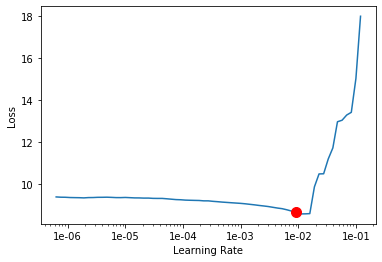

In [61]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
lr = 3e-3

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.625214,3.631252,0.442010,0.202834,01:08
1,2.473791,4.155777,0.456205,0.353423,00:57
2,2.333935,2.594567,0.600239,0.334758,00:59
3,2.532168,3.912492,0.435558,0.362345,00:53
4,2.803010,3.758590,0.441598,0.362115,00:52
5,3.233417,4.150254,0.389770,0.316221,00:50
6,3.566119,4.419960,0.360209,0.276825,00:47
7,3.213755,4.220668,0.379199,0.295937,00:48
8,2.887079,3.603829,0.446473,0.337771,00:50
9,2.572257,3.599997,0.452566,0.355292,00:51


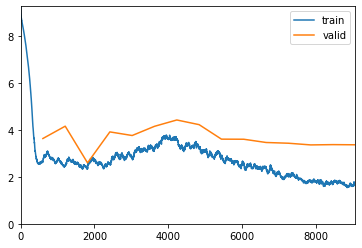

In [63]:
learn.fit_one_cycle(15, max_lr=lr)

# 6. View Results

In [32]:
inputs, targets, outputs = get_predictions(learn)

In [33]:
idx = 999
inputs[idx], targets[idx], outputs[idx]

(Text xxbos quelles sont les données ventilées par sexe pertinentes , qui ne sont pas utilisées habituellement , mais sont disponibles et accessibles ?,
 Text xxbos what relevant gender - xxunk data is not currently used but available and accessible ?,
 Text xxbos what is - - - - , not not not not used , and available ? ?)

In [34]:
idx = 2222
inputs[idx], targets[idx], outputs[idx]

(Text xxbos avez - vous xxunk des xxunk ou de xxunk en afghanistan parce que vous êtes une femme ?,
 Text xxbos what about yourself xxunk : have you experienced resistance or xxunk in afghanistan because you ’re a woman ?,
 Text xxbos what are your you as a a a a in in)

In [35]:
idx = 3333
inputs[idx], targets[idx], outputs[idx]

(Text xxbos quels genres d’innovations organisationnelles apporte - t - on à l’intérieur de ce système ?,
 Text xxbos what kinds of organizational innovation takes place in this system ?,
 Text xxbos what type of organizational support to this this system ?)

In [36]:
idx = 4444
inputs[idx], targets[idx], outputs[idx]

(Text xxbos dans quels cas la discussion informelle a - t - elle lieu ?,
 Text xxbos when does informal discussion occur ?,
 Text xxbos what was the informal discussion informal discussion ?)

# 7. สรุป

* เราได้เรียนรู้


ตารางสรุป ผลลัพธ์การเทรนโมเดลแบบต่าง ๆ

model            | train_loss | valid_loss | seq2seq_acc | bleu
-------------------|----------|----------|----------|----------
seq2seq            | 2.823382 | 3.826643 | 0.427117 | 0.322879
\+ teacher forcing | 2.678760 |	3.732396 | 0.439311 | 0.332833
\+ attention       | 1.452292 | 3.420485 | 0.498205 | 0.413232
transformer        | 1.913152 | 2.349686 | 0.781749 | 0.612880

# Credit

* https://www.youtube.com/watch?v=IfsjMg4fLWQ&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=12
* https://www.bualabs.com/archives/3134/what-is-sequence-to-sequence-neural-translate-machine-translation-french-to-english-sequence-to-sequence-model-rnn-gru-teacher-forcing-nlp-ep-10/
* https://www.bualabs.com/archives/3103/what-is-recurrent-neural-network-rnn-pytorch-gru-nlp-ep-9/
* https://www.bualabs.com/archives/3087/sentiment-classification-deep-learning-imdb-movie-reviews-positive-negative-deep-neural-network-awd-lstm-ulmfit-nlp-ep-8/
* https://www.bualabs.com/archives/3060/what-is-n-gram-sentiment-classification-imdb-movie-review-naive-bayes-logistic-regression-nlp-ep-6/
* http://opus.nlpl.eu/giga-fren.php
* https://arxiv.org/abs/1409.3215
* https://ieeexplore.ieee.org/document/6795228/
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* http://www.statmt.org/wmt15/translation-task.html
* https://fasttext.cc/docs/en/crawl-vectors.html
* https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213
* https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
* https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb
* 